In [1]:
from data import series_data
from importlib import import_module
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
#from util import train, plot_confusion_matrix, plot_loss_accuracy, plot_dataloader_distribution
from util import train, plot_loss_accuracy, plot_dataloader_distribution

import matplotlib.pyplot as plt 
import numpy as np 
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn




C:\Users\giuli\anaconda3\envs\ecg_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

dataset_name = 'Casilino'
model_name = 'AutoencoderCNN'
rearrange_tensor = False
#units = 1000
#layer_config = [(500, nn.ReLU),(300, nn.ReLU),(150, nn.ReLU),(50, nn.ReLU),(20, nn.ReLU),(8, nn.ReLU),(4, nn.ReLU),(2,nn.Tanh),]
k=15000     
#layers = 0
batch = 200
epochs = 100
device = 'cpu'
s_len=250

torch.Size([23457, 1, 250])


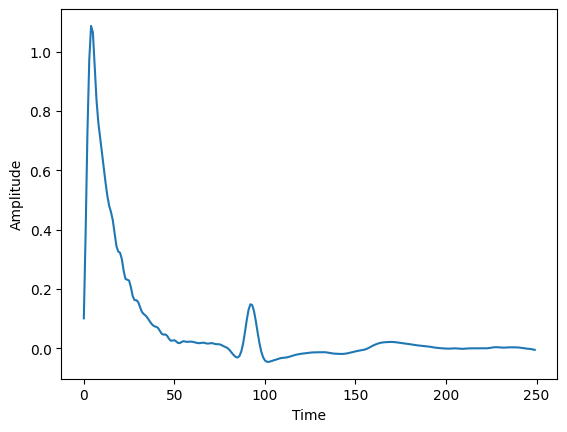

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

dataset = import_module('datasets.' + dataset_name)
model = getattr(import_module('model'), model_name)

ts, labels = dataset.load_data()


if rearrange_tensor:
    ts = ts.transpose(1, 2)
  

  
n_labels = int(labels.max()) + 1



print(ts.shape)

label_names = dataset.get_label_names()

indice=10
patient=ts[indice,:].squeeze(0)
patient_n=patient.numpy()
fig, ax1 = plt.subplots(1, 1)
ax1.plot(np.arange(250),patient[:], label='Original Signal')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')







data = series_data.Series(ts, labels, {'RandomScaling':[0.5],'RandomAmplitudeFlip':[0.5],'RandomBiasShift':[0.5], 'RandomOscillationAdd': [0.5]})

#ts_norm=(ts-ts.min())/(ts.max()-ts.min())
#mms = MinMaxScaler()
ss=StandardScaler()
ts = ts.squeeze(1)

ts = ss.fit_transform(ts)
#print(ts.shape)
#ts=ts.unsqueeze(1)


In [4]:
train_size = int(0.8 * len(data))
valid_size = int((len(data) - train_size)/2)
test_size = int(len(data) - train_size -valid_size)
print(f'{len(data)} = {train_size} {valid_size} {test_size}')
train_data, valid_data, test_data = random_split(data, [train_size, valid_size,test_size])

#print(train_data[0][0].shape)


segmented_data= [[],[],[]]
t=0
for d in [train_data,valid_data,test_data]:
    for s in d: 
    # print(d.shape)
        for i in range(0, s[0].shape[1] -s_len +1 ,s_len ):
            segment = s[0][:,i : i+s_len]
            segmented_data[t].append(segment)
    t=t+1

#print(len(segmented_data[2]))   
         
         


train_loader = DataLoader(segmented_data[0], batch_size=batch, shuffle=True)
validation_loader = DataLoader(segmented_data[1], batch_size=batch, shuffle=False)
test_loader = DataLoader(segmented_data[2], batch_size=batch, shuffle=False)


#train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
#validation_loader = DataLoader(valid_data, batch_size=batch, shuffle=False)
#test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)








print(ts)

net = model().to(device)   
    
    
print(f'The number of samples for training is {train_size}.')
class_samples = [int(sum(labels==l))/len(labels) for l in range(n_labels)]
print(f'Samples per classes: {class_samples}')
class_samples_train = [sum([int(t[1])==l for t in list(train_data)])/len(list(train_data)) for l in range(n_labels)]
print(f'Samples per classes (training): {class_samples_train}')
class_samples_valid = [sum([int(v[1])==l for v in list(valid_data)])/len(list(valid_data)) for l in range(n_labels)]
#print(f'Samples per classes (validation): {class_samples_valid}')
print(f'The number of parameters is {sum(p.numel() for p in net.parameters())}.')

#ax1.plot(np.arange(250),data.__getitem__(6)[0][0].numpy()[1000:1250] , label='Augmented Signal')
#ax1.legend()


23457 = 18765 2346 2346
[[ 1.44390090e+00  1.44445714e+00  1.44488427e+00 ... -1.72023451e+00
  -1.66158821e+00 -1.61120243e+00]
 [ 2.97537554e+00  2.97638878e+00  2.97709282e+00 ... -8.01044279e-02
  -6.45785304e-02 -5.45453791e-02]
 [ 1.59169186e+00  1.59174372e+00  1.59128640e+00 ... -2.84999378e-03
   1.49005035e-02  2.84529266e-02]
 ...
 [-4.00137845e-01 -4.00714196e-01 -4.01547602e-01 ... -1.63250125e-02
  -1.98967080e-02 -2.59969044e-02]
 [-4.06077561e-01 -4.06237588e-01 -4.06323317e-01 ... -2.59638243e-02
  -3.79604741e-02 -5.64097353e-02]
 [-4.00137845e-01 -4.00504659e-01 -4.00850599e-01 ... -6.34078113e-02
  -8.25722222e-02 -1.03163419e-01]]
The number of samples for training is 18765.
Samples per classes: [1.0]
Samples per classes (training): [1.0]
The number of parameters is 261953.


(23457, 250)
(23457, 250)


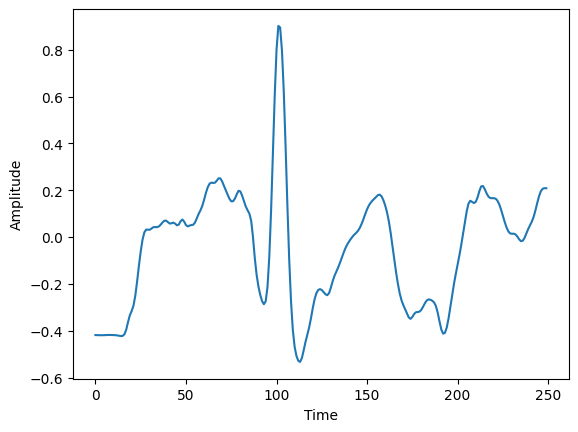

In [5]:
#ts_squeezed= ts.squeeze(1)
#print(ts.shape)
indice=330
patient=ts[indice,:]
#patient_n=patient.numpy()
fig, ax1 = plt.subplots(1, 1)
ax1.plot(np.arange(250),patient[:], label='Original Signal')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
print(ts.shape) 
#print(patient)
print(ts.shape)

In [6]:
#plot_dataloader_distribution(train_loader, label_names)

In [7]:
#class_weights = [1/sum([int(t[1])==l for t in list(train_data)]) for l in range(n_labels)]
#sample_weights = [class_weights[int(t[1])] for t in list(train_data)]
#sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_data), replacement=True)
#rebalanced_loader = DataLoader(train_data, sampler=sampler, batch_size=batch)

In [8]:
#plot_dataloader_distribution(rebalanced_loader, label_names)

In [ ]:

train_loss, validation_loss = train(
    net, device, train_loader, validation_loader, epochs, lr=0.0001, weight_decay=0
)

Training:  79%|███████▉  | 79/100 [2:03:04<32:27, 92.74s/epoch, loss=5.81e-5]   

In [ ]:
print(net)

In [ ]:
plot_loss_accuracy(train_loss, validation_loss, batch= batch)


In [ ]:
#plot_confusion_matrix(target_list, predicted_list, label_names)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


#real= ts[10000, :]
#print(labels[10000])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
#print(len(segmented_data[2]))
real=segmented_data[2][160]
#real=ts[100,:]
print(real.shape)

#print(len(real[0]))
#real=real[100]

ax1.plot(np.arange(s_len), real.squeeze(0), label='Original Signal', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.legend()
#real = torch.from_numpy(real)
#print(real.shape)
real = real.float()
#print(real.unsqueeze(0).unsqueeze(0))
fake = net(real.unsqueeze(0))
#print(fake)

ax2.plot(np.arange(s_len), fake[:].detach().numpy().squeeze(0).squeeze(0), label='Reconstructed Signal', color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')
ax2.legend()

plt.show()
#print(ts)

In [ ]:

fig, ax1 = plt.subplots(1, figsize=(15, 5))
#print(len(segmented_data[2]))
real=segmented_data[2][90]
#real=ts[100,1000:1250]
#print(len(real[0]))
#real=real[100]

ax1.plot(np.arange(s_len), real.squeeze(0), label='Original Signal', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.legend()
#real = torch.from_numpy(real)
#print(real.shape)
real = real.float()
#print(real.unsqueeze(0).unsqueeze(0))
fake = net(real)
#print(fake)

ax1.plot(np.arange(s_len), fake[:].detach().numpy().squeeze(0), label='Reconstructed Signal', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.legend()

plt.show()

In [ ]:
ts1,labels1= dataset.load_data1(t_len =15000, k=k)
if rearrange_tensor:
    ts1 = ts1.transpose(1, 2)

  
data1 = series_data.Series(ts1, labels1)
print(labels1)
label_names1 = dataset.get_label_names1()

ss=StandardScaler()
#print(ts1.shape)
#ts1 = ts1.squeeze(1)

#ts1 = ss.fit_transform(ts1)

print(ts1.shape)


In [ ]:

#print(segmented_data1[0].size)
fig, ax3 = plt.subplots(1, figsize=(15, 5))
real1 =ts1[130,0,1500:1750]


#real1=real1.numpy()
ax3.set_xlabel('Time')
ax3.set_ylabel('Amplitude')

#real1 = torch.from_numpy(real1)
real1 = real1.float()
#print(real.unsqueeze(0).unsqueeze(0))
fake = net(real1.unsqueeze(0))
#print(fake)

ax3.plot(np.arange(250), fake[:].detach().numpy().squeeze(0) ,label = 'Reconstructed Signal', color='orange')
ax3.set_xlabel('Time')
ax3.set_ylabel('Amplitude')
ax3.legend()
ax3.plot(np.arange(250), real1.squeeze(0), label = 'Original Signal', color='blue')
ax3.legend()
plt.show()

In [ ]:
fake_np = fake.detach().numpy().squeeze(0)
real1_np = real1.squeeze(0).detach().numpy()

error = np.abs(fake_np - real1_np)
#print(error)
area_difference = np.trapz(error, np.arange(250))

# Plot dei segnali sovrapposti
plt.plot(fake_np, label='Fake Signal')
plt.plot(real1_np, label='Real Signal')

# Plot dell'area di differenza
plt.fill_between(np.arange(250), 0, error.ravel(), color='red', alpha=0.3, label='Error Area')

# Impostazioni del grafico
plt.title('Differenza tra due segnali')
plt.xlabel('Tempo')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Mostra il grafico
plt.show()

# Stampa dell'area della differenza
print(f'Area della differenza: {area_difference}')








In [ ]:
torch.save(model.state_dict(), 'AutoencoderCNN.pth')

model = AutoencoderCNN()

model.load_state_dict(torch.load('AutoencoderCNN.pth'))